<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Machine Learning Using Python (MEAFA Workshop)</h1>
<h2 align="center" style="margin-top:10px">Lesson 3: Naive Bayes and Sentiment Analysis</h2>
<br>

Sentiment analysis is the task of classifying text documents according to the attitude of the writer (or speaker in case of transcription). Sentiment analysis has several applications in areas such as marketing, where online comments, reviews, and messages provide a wealth of data about customers that can be leveraged towards improved brand and customer relationship management strategies. 

One way to approach this problem is to use a [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model), which represents the document as a numerical vector. Each element of the vector counts the number or times a word appears in the document, or simply if the word appears in the text (leading to a binary vector).  This is of course a substantial simplification since it disregards the linguistic structure of the document. 


<a href="#Data:-Twitter-Airline-Sentiment">Data: Twitter Airline Sentiment</a> <br>
<a href="#Text-Processing">Text Processing</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Bayes'-Rule">Bayes' Rule</a> <br>
<a href="#Data-Preparation">Data Preparation</a> <br>
<a href="#Naive-Bayes">Naive Bayes</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import nltk
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods from previous lessons
from sklearn.model_selection import train_test_split, cross_val_score

##Data: Twitter Airline Sentiment

In this lesson we use the [Twitter Arline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) dataset provided by a company called [Crowdflower](https://www.crowdflower.com/) on the [Kaggle datasets](https://www.kaggle.com/datasets) page. To build this dataset, the data scientists at Crowdflower scraped all tweets addressed at US airlines in the month of February 2015, including metadata about the message. 

Human contributors then categorised each tweet according to the sentiment (positive, neutral, or negative) expressed by the author. 

In [4]:
data=pd.read_csv('Datasets/Tweets.csv')
data.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In sentiment analysis, it is common to use hierachical classifiers that first classify a document as expressing a neutral or non-neutral sentiment, and then classify the sentiment in the documents that are predicted to be polar. Therefore, we simplify our analysis to consider only positive and negatives tweets. Furthermore, we only keep the tweets that were classified with full confidence by the contributors. 

In [5]:
data=data[data['airline_sentiment']!='neutral']
data=data[data['airline_sentiment_confidence']==1.0]

In [6]:
len(data)

8897

Here are examples of negative and positive tweets respectively.

In [7]:
data.loc[4126, 'text']

'@united stuck here in IAH waiting on flight 253 to Honolulu for 7 hours due to maintenance issues. Could we have gotten a new plane!?!? Fail'

In [8]:
data.loc[8644, 'text']

'@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!'

## Data processing

### Text processing

Text analysis requires careful processing of the raw text data to convert documents into a format that is amenable to analysis. The four steps that we implement here are:


<ol style="margin-left: -10px">
  <li style="margin-top: 12px;"> Tokenization: separate the text into words for a bag of words represenation.</li>
  <li style="margin-top: 12px;">Removing uninformative punctuation.</li>
  <li style="margin-top: 12px;">Removing stopwords (non-discriminative words such as "the" and "to").</li>
  <li style="margin-top: 12px;">Stemming and lemmatization: converting words to a root form. Say, it may be more useful to consider "democracy", "democracies", "democratic", and "democratization" as the same token.</li>
</ol>

In [9]:
from nltk.tokenize import TweetTokenizer

tweet=data.loc[8644, 'text'] 
Tokenizer = TweetTokenizer()
tokenized = Tokenizer.tokenize(tweet)


print('Original:')
print(tweet)
print('\nTokenized:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenized:
['@JetBlue', 'had', 'a', 'great', 'flight', 'to', 'Orlando', 'from', 'Hartford', 'a', 'few', 'weeks', 'ago', '!', 'Was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


In [10]:
import string
tokenized_no_punctuation=[word.lower() for word in tokenized if word not in string.punctuation]
print(tokenized_no_punctuation)

['@jetblue', 'had', 'a', 'great', 'flight', 'to', 'orlando', 'from', 'hartford', 'a', 'few', 'weeks', 'ago', 'was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early']


In [11]:
from nltk.corpus import stopwords
tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
print(tokenized_no_stopwords)

['@jetblue', 'great', 'flight', 'orlando', 'hartford', 'weeks', 'ago', 'great', 'get', 'time', 'arrive', 'early']


There are different methods for stemming and lemmatization immediately available in the NLTK package. We pick one below.

In [12]:
from nltk.stem.porter import PorterStemmer
tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords]
print(tokens)

['@jetblu', 'great', 'flight', 'orlando', 'hartford', 'week', 'ago', 'great', 'get', 'time', 'arriv', 'earli']


We put all these steps below into a function that we can apply to the tweets to create a data column containing the tokens. 

In [13]:
# this cell may take over a minute to run

def process_text(text):
    tokenized = Tokenizer.tokenize(text)
    tokenized_no_punctuation=[word.lower() for word in tokenized if word not in string.punctuation]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    return tokens

data['tokens']=data['text'].apply(process_text) # applies a function separately to each element of a column      

Let's have a look at the results. Clearly, there would still be room for improvement as we discarded the emojis. 

In [14]:
data[['text','tokens']].head(10)

,text,tokens
3,@VirginAmerica it's really aggressive to blast...,"[@virginamerica, realli, aggress, blast, obnox..."
4,@VirginAmerica and it's a really big bad thing...,"[@virginamerica, realli, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a fligh...,"[@virginamerica, serious, would, pay, 30, flig..."
9,"@VirginAmerica it was amazing, and arrived an ...","[@virginamerica, amaz, arriv, hour, earli, good]"
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,"[@virginamerica, <3, pretti, graphic, much, be..."
12,@VirginAmerica This is such a great deal! Alre...,"[@virginamerica, great, deal, alreadi, think, ..."
14,@VirginAmerica Thanks!,"[@virginamerica, thank]"
16,@VirginAmerica So excited for my first cross c...,"[@virginamerica, excit, first, cross, countri,..."
17,@VirginAmerica I flew from NYC to SFO last we...,"[@virginamerica, flew, nyc, sfo, last, week, f..."
18,I ❤️ flying @VirginAmerica. ☺️👍,"[❤, fli, @virginamerica, ☺, 👍]"


###Data Splitting

We split the data into training and test sets before proceeding. 

In [15]:
# Construct response
data['positive']=(data['airline_sentiment']=='positive').astype(int)

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

##Exploratory Data Analysis

We start with some exploratory data analysis for the training data. We find that overall 82.6% of the tweets are negative and 17.4% are positive.

In [16]:
train['airline_sentiment'].value_counts()

negative    5176
positive    1051
Name: airline_sentiment, dtype: int64

In [17]:
train['airline_sentiment'].value_counts(normalize=True).round(3)

negative    0.831
positive    0.169
Name: airline_sentiment, dtype: float64

We can use cross tabulation to break down the numbers by airline.

In [18]:
table=pd.crosstab(train['airline_sentiment'], train['airline'])
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1156,467,632,1334,1491,96
positive,148,241,268,111,210,73


American, US Airways, and United in particular had a high proportion of complaints that month.

In [19]:
table = (table/table.sum()).round(3)
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,0.887,0.66,0.702,0.923,0.877,0.568
positive,0.113,0.34,0.298,0.077,0.123,0.432


In graphical format: 

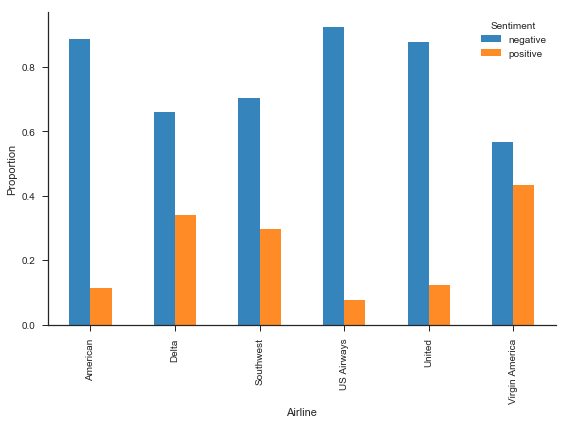

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
(table.T).plot(kind='bar', alpha=0.9,ax=ax)
ax.set_xlabel('Airline')
ax.set_ylabel('Proportion')
ax.legend_.set_title('Sentiment')
plt.tight_layout()
sns.despine()
plt.show()

Our main challenge in building the classifier will be to select the features to include in the model. A good way to start is to explore the most common words in each type of document.  We first consider the most common words in the data as a whole. 

In [21]:
fdist = nltk.FreqDist()
for words in train['tokens']:
    for word in words:
            fdist[word] += 1

fdist.most_common()[:20]

[('flight', 2340),
 ('@unit', 1734),
 ('@usairway', 1494),
 ('@americanair', 1399),
 ('@southwestair', 917),
 ('get', 739),
 ('thank', 729),
 ('@jetblu', 722),
 ('hour', 715),
 ('delay', 583),
 ('cancel', 579),
 ('servic', 563),
 ('custom', 543),
 ('time', 525),
 ('help', 459),
 ('...', 446),
 ('wait', 429),
 ('call', 425),
 ('bag', 414),
 ('hold', 414)]

With a bit of work, we can turn this into a plot.

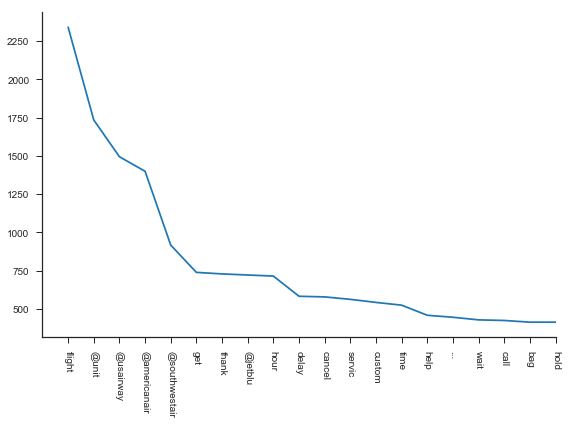

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

y = pd.Series(dict(fdist.most_common()[:20]))
y = y.sort_values(ascending=False)

y.plot()

indexes = np.arange(0, len(y)) # we will place ticks for every word
ax.set_xticks(indexes)
ax.set_xticklabels(y.index, rotation='-90')
ax.set_xlim(-1)

plt.tight_layout()

sns.despine()
plt.show()

Now, let's repeat something similar for positive and negative tweets separately. We introduce some changes by computing the proportion of tweets in which the word appears and then sorting the words accordingly in descending order. 

This analysis gives us important clues for building a classifier. First, nearly half of the positive tweets contain the "thank" word, suggesting that this will be a powerful feature for classification. Not surprisigly, word such as "great", "love", "best", and "awesome" are among the most frequent in the positive tweets, and do not appear among the most frequent negative tweets. In the same way, "delay", "cancel", and "wait" are among the most frequent for negative tweets and are not among the most frequent among positive tweets.

A third group of words such as "flight" and "service" are frequent among both positive and negative tweets and may not be very useful for classification. 

In [23]:
positives=len(train[train['airline_sentiment']=='positive']) # number of positive tweets in the training data

fdist_positive = nltk.FreqDist()
for words in train[train['airline_sentiment']=='positive']['tokens']:
    for word in np.unique(words): # not counting repeated words this time
            fdist_positive[word] += 1

            
common_positive = pd.Series(dict(fdist_positive))/positives # there is probably a better way to do this
common_positive = common_positive.sort_values(ascending=False)
common_positive.head(20).round(3)

thank             0.476
@southwestair     0.256
@jetblu           0.230
@unit             0.201
flight            0.178
@americanair      0.149
great             0.119
@usairway         0.110
servic            0.084
love              0.081
@virginamerica    0.069
custom            0.068
fli               0.068
best              0.066
guy               0.064
help              0.060
good              0.053
get               0.052
much              0.050
awesom            0.049
dtype: float64

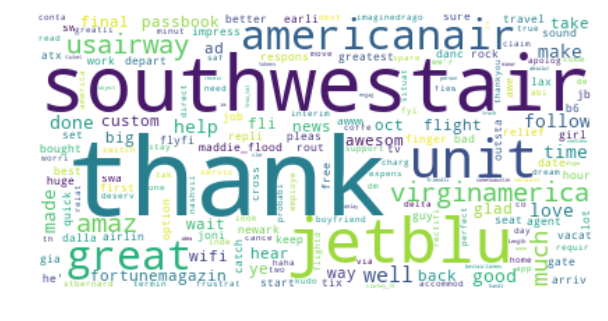

In [24]:
positive_tweets = train[train['airline_sentiment']=='positive']['tokens']

from wordcloud import WordCloud

fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", max_words=200).generate(str(positive_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
negatives=len(train[train['airline_sentiment']=='negative'])

fdist_negative = nltk.FreqDist()
for words in train[train['airline_sentiment']=='negative']['tokens']:
    for word in np.unique(words): 
            fdist_negative[word] += 1

common_negative = pd.Series(dict(fdist_negative))/negatives
common_negative = common_negative.sort_values(ascending=False)
common_negative.head(20).round(3)

flight           0.320
@unit            0.292
@usairway        0.264
@americanair     0.239
hour             0.128
@southwestair    0.125
get              0.124
cancel           0.103
delay            0.102
@jetblu          0.092
servic           0.089
custom           0.088
time             0.086
hold             0.076
wait             0.075
help             0.073
call             0.071
...              0.071
bag              0.067
plane            0.060
dtype: float64

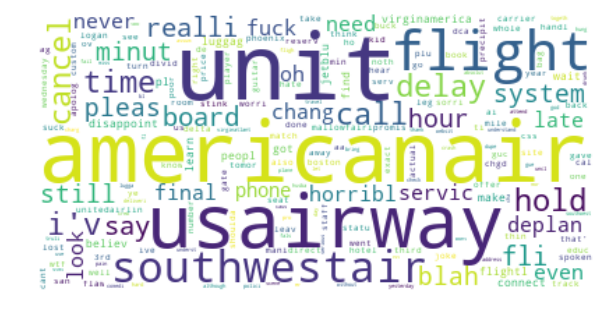

In [26]:
negative_tweets = train[train['airline_sentiment']=='negative']['tokens']

from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", max_words=200).generate(str(negative_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##Bayes' Rule

We are ready to build a simple classifier based on one feature. As a baseline, we compute the test misclassification rate from always predicting negative (we rely on the test data early on this time for illustrative purposes).

In [27]:
from sklearn.metrics import accuracy_score
error  = 1 - accuracy_score(np.zeros(len(test)), test['positive'])
print(error.round(3))

0.174


As a learning experience, we first manually implement a classifier based on the Bayes rule and one feature.

In [28]:
# a useful future suggested by our analysis above
feature = 'thank'

# Response: simply retrieving the values in the respose value (as a NumPy array, for technical reasons) 
y_train=train['positive'].values

# Feature
# Create a True/False variable that records if the word appears in each tweet
# The lambda defines an anonymous function, which is function that we define in context
X_train=train['tokens'].apply(lambda tokens: (feature in tokens))
X_train.astype(int).values  # Convert to a dummy variable in NumPy array format
           
# Proportion of positives in the training data   
pi=np.mean(y_train) 

# Proportion of positive tweets that contain the feature
theta1=np.sum(X_train*y_train)/np.sum(y_train)

# Proportion of positive tweets that contain the feature
theta0=np.sum(X_train*(1-y_train))/np.sum(1-y_train)

# Probability of a positive conditional on the feature, using Bayes' theorem
prob = (pi*theta1)/(pi*theta1+(1-pi)*theta0)

We estimate that conditional on the appearance of the token "thank", the document has 70.6% probability of being positive. This is because around 48% of positive tweets have this token, while only 4% of negative tweets do.

In [29]:
print(prob.round(3))
print(theta0.round(3))
print(theta1.round(3))

0.706
0.04
0.476


The appearance of "thank" would therefore lead to us to classify a tweet as positive. Let's evaluate the performance of the model for the test data. 

In [30]:
y_pred = test['tokens'].apply(lambda tokens: (feature in tokens))
error  = 1 - accuracy_score(test['positive'], y_pred)
print(error.round(3))

0.116


We reduce the test misclassification rate from 17.4% to 11.6%, a good improvement!

We now switch to the Scikit-Learn implementation of the Naive Bayes method. It is convenient to write a function that creates a design matrix in the format required by Scikit-Learn. 

In [31]:
from sklearn.naive_bayes import BernoulliNB

def design_matrix(feature, series):
    X=series.apply(lambda tokens: (feature in tokens))
    X= X.astype(int) 
    return X.values.reshape((-1,1)) # converting to a NumPy matrix, as required

X_train = design_matrix('thank', train['tokens'])
X_test = design_matrix('thank', test['tokens'])

nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
pred = nbc.predict(X_test)
error  = 1 - accuracy_score(pred, test['positive'])
print(error.round(3))   

0.116


##Data preparation

Before implementing the full algorithm, we need a strategy for handling the large number of features and processing them into a design matrix. 

We follow a simple approach and first rank the features according to the performance of univariate models based on each of them. We can use the code from the EDA part to retrieve a list of features and the corresponding counts.

In [32]:
features = pd.Series(dict(fdist))
features = features.sort_values(ascending=False)
features.head()

flight           2340
@unit            1734
@usairway        1494
@americanair     1399
@southwestair     917
dtype: int64

Below are the descriptive statistics for the counts. There are 7833 unique tokens, but more than half appear only once in the training data. 

In [33]:
features.describe().round(0)

count    7833.0
mean        9.0
std        53.0
min         1.0
25%         1.0
50%         1.0
75%         3.0
max      2340.0
dtype: float64

A token with a single training case would lead us to estimate that the associated response class (positive or negative) has probability one conditional on that feature, which is clearly overfitting. Hence, we set a minimum of ten cases for us to include the predictor in the analysis, bringing the number of features to 938. 

In [34]:
features = features[features>=10]
len(features)

938

We rank the features according to the training cross-entropy loss, which is based on the estimated conditional probabilities. This makes more sense here as the probabilities are more informative than binary classifications (most features do not change the classification on their own). In statistical terms, the cross-entropy loss is the negative log-likelihood of the response data given the estimated probabilities. 

In [35]:
from sklearn.metrics import log_loss

def training_error(feature):
    X_train = design_matrix(feature, train['tokens'])
    nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    prob = nbc.predict_proba(X_train)
    return log_loss(y_train, prob)

The ranking of the features is as follows.

In [36]:
losses=[]
for feature in features.index:
    losses.append(training_error(feature))

ranked = pd.Series(losses, index=features.index)
ranked = ranked.sort_values()
ranked.head(20)

thank             0.356649
great             0.431398
hour              0.437332
love              0.440026
@jetblu           0.442706
best              0.442837
awesom            0.443293
:)                0.443361
@usairway         0.443509
hold              0.443884
cancel            0.443928
amaz              0.443986
delay             0.444786
@southwestair     0.445417
flight            0.446594
appreci           0.447398
flightl           0.447499
call              0.447919
min               0.448830
@virginamerica    0.448916
dtype: float64

Finally, we need to write a function to build the design matrix given a list of features. As a very technical detail, we build it as a sparse matrix for memory efficiency. This is because the design matrix can become extremely large in this type of application (millions of entries), but the vast majority of the elements are zero. 

In [37]:
from scipy.sparse import lil_matrix

def design_matrix(features, series):
    X = lil_matrix((len(series),len(features))) # initialise 
    for i in range(len(series)): 
        tokens = series.iloc[i]
        for j, feature in enumerate(features): # scan the list of features
            if feature in tokens: # if the feature is among the tokens, 
                X[i, j]= 1.0
    return X

##Naive Bayes

The next cell computes the test error when when use the 10 highest ranked features. We obtain a misclassification rate of 9% for the test data. 

In [38]:
p = 10

y_test = test['positive'].values
features = list(ranked.index) # storing the list of features in order for later

X_train = design_matrix(features[:p], train['tokens'])
X_test = design_matrix(features[:p], test['tokens'])

nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
y_pred = nbc.predict(X_test)
error  = 1 - accuracy_score(y_test, y_pred)
print(error.round(4)) 

0.0903


How many features should we use? As always, we use cross validation. 

Due to the large number of features and observations, cross validation can be slow for this data. We therefore increase the number of predictors by 20 in each step to save time. We also compute the test errors for comparison. 

In [39]:
# This cell will take a couple of minutes to run, increase the leap in the loop if needed

from sklearn.model_selection import cross_val_score

test_errors = []
cv_errors = []

n_features = np.arange(0, len(features)+1, 20)
n_features[0] = 1 # the first model has 1 feature, then 20, 40, etc

for p in n_features:
    X_train = design_matrix(features[:p], train['tokens'])
    X_test = design_matrix(features[:p], test['tokens'])
    nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    
    scores = cross_val_score(nbc, X_train, y_train, cv=10, scoring = 'accuracy')
    cv_errors.append(1-np.mean(scores))
    
    y_pred = nbc.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred)) 

The results illustrate that the Naive Bayes method is relatively immune to overfitting. We obtain the best cross validation score with around 260 predictors, but remarkably the performance does not importantly deteriorate if we increase the number of features to include all of them.

The selected model has 93% classification accuracy for the test data. 

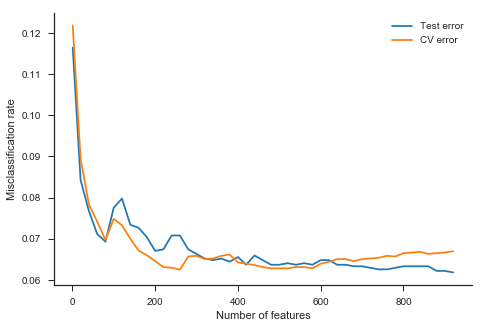

Lowest CV error: K = 260
Lowest test error: K = 920

Test misclassification rate for the selected model = 0.071


In [40]:
fig, ax= plt.subplots(figsize=(7.5,5))
ax.plot(n_features, test_errors, label='Test error')
ax.plot(n_features, cv_errors, label='CV error')
ax.set_xlabel('Number of features')
ax.set_ylabel('Misclassification rate')
plt.legend()
sns.despine()
plt.show()

print(f'Lowest CV error: K = {n_features[np.argmin(cv_errors)]}') 
print(f'Lowest test error: K = {n_features[np.argmin(test_errors)]}')  

print(f'\nTest misclassification rate for the selected model = {test_errors[np.argmin(cv_errors)]:.3f}')  

##Model evaluation

We conclude our analysis by evaluating our selected model. The next cell computes the class predictions and the predicted probabilities.

In [41]:
p=260
X_train = design_matrix(features[:p], train['tokens'])
X_test = design_matrix(features[:p], test['tokens'])
nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    
y_pred = nbc.predict(X_test) # classification
y_prob = nbc.predict_proba(X_test) # predicted probabilities

With the results we can build a table with common classification metrics. 

In [42]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix

columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Naive Bayes']
results=pd.DataFrame(0.0, columns=columns, index=rows)

confusion  = confusion_matrix(y_test,  y_pred) 
results.iloc[0,0]=  1 - accuracy_score(y_test, y_pred)
results.iloc[0,1]=  recall_score(y_test, y_pred)
results.iloc[0,2]=  confusion[0,0]/np.sum(confusion[0,:])
results.iloc[0,3]=  roc_auc_score(y_test, y_prob[:,1])
results.iloc[0,4]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Naive Bayes,0.071,0.828,0.951,0.97,0.779


The results show that the classifier has a sensitivity of 82.8% and specificity of 95.1%. That is, it has 82.8% probability of correctly classifying a positive comment and 95.1% probability of correctly classifying a negative comment. 

We can report the confusion matrix in graphical format as follows. 

Normalized confusion matrix


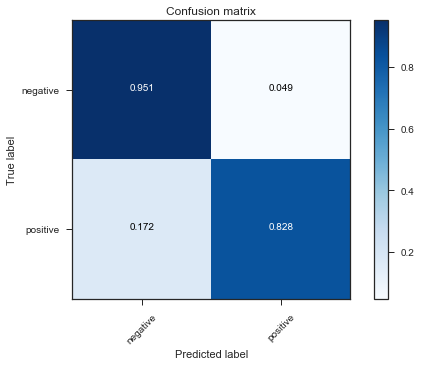

In [43]:
from statlearning import plot_confusion_matrix

confusion  = confusion_matrix(y_test, y_pred)  # the true class is the first argument in all these functions

fig, ax = plt.subplots(figsize=(7,5))
plot_confusion_matrix(confusion, classes=['negative','positive'], normalize=True)
plt.show()

Next, we plot the ROC curve. We can a achieve a sensitivity of around 93% if we are willing to accept a false positive rate of 10%. However, the false positive rate increases sharply if we try to improve the sensitivity beyond that. 

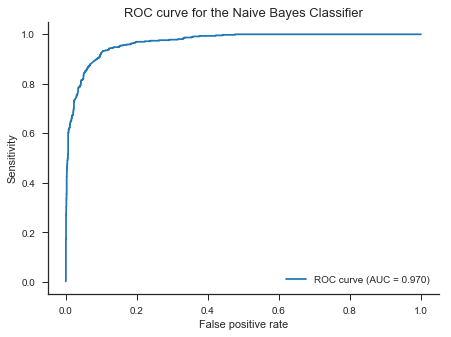

In [44]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
auc = roc_auc_score(y_test, y_prob[:,1])

fig, ax= plt.subplots(figsize=(7,5))
ax.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
ax.set_xlabel('False positive rate')
ax.set_ylabel('Sensitivity')
ax.set_title('ROC curve for the Naive Bayes Classifier', fontsize=13)
sns.despine()
plt.legend()
plt.show()